## 1. Iris 데이터셋을 활용해 클래스별 변수 평균 차이를 검정

### 1) IRIS 데이터 호출

In [9]:
import seaborn as sns

# seaborn 내장 iris 데이터셋 로드
iris = sns.load_dataset('iris')

iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [10]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


### 2) 기초통계량 산출

In [11]:
import pandas as pd

print(iris['species'].value_counts())

# 종별 기초 통계량 산출
iris.groupby('species')['petal_length'].describe()

species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64


,count,mean,std,min,25%,50%,75%,max
species,,,,,,,,
setosa,50.0,1.462,0.173664,1.0,1.4,1.50,1.575,1.9
versicolor,50.0,4.260,0.469911,3.0,4.0,4.35,4.600,5.1
virginica,50.0,5.552,0.551895,4.5,5.1,5.55,5.875,6.9


### 3) 시각화 - boxplot

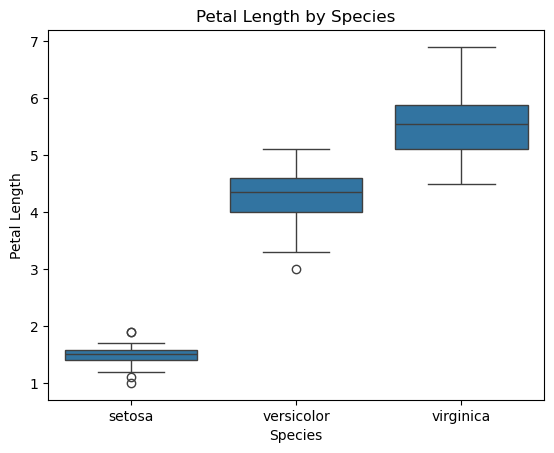

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.boxplot(x='species', y='petal_length', data=iris)
plt.title('Petal Length by Species')
plt.xlabel('Species')
plt.ylabel('Petal Length')
plt.show()


In [13]:
# Step 3: 간단한 해석
group_means = iris.groupby('species')['petal_length'].mean()
print("그룹별 평균 Petal Length:")
print(group_means)

# 한 줄 요약 해석
print("\n 📝 해석:")
print("→ Virginica가 가장 길고, Setosa가 가장 짧습니다.")

그룹별 평균 Petal Length:
species
setosa        1.462
versicolor    4.260
virginica     5.552
Name: petal_length, dtype: float64

 📝 해석:
→ Virginica가 가장 길고, Setosa가 가장 짧습니다.


### 4) Shapiro-Wilk 정규성 검정
- 유의수준: α = 0.05
- 각 그룹의 p-value > 0.05이면 정규성 유지 판단



In [14]:
from scipy.stats import shapiro

# Species별로 Shapiro-Wilk 정규성 검정
for species in iris['species'].unique():
    data = iris[iris['species'] == species]['petal_length']
    stat, p = shapiro(data)
    print(f"{species}; p-value: {p:.4f} → {'정규성 있음' if p > 0.05 else '정규성 없음'}")


setosa; p-value: 0.0548 → 정규성 있음
versicolor; p-value: 0.1585 → 정규성 있음
virginica; p-value: 0.1098 → 정규성 있음


### 5) Levene 등분산성 검정

In [15]:
from scipy.stats import levene

# Levene 등분산성 검정
setosa = iris[iris['species'] == 'setosa']['petal_length']
versicolor = iris[iris['species'] == 'versicolor']['petal_length']
virginica = iris[iris['species'] == 'virginica']['petal_length']

stat, p = levene(setosa, versicolor, virginica)
print(f"Levene test p-value: {p:.4f} → {'등분산성 있음' if p > 0.05 else '등분산성 없음'}")


Levene test p-value: 0.0000 → 등분산성 없음


### 6) ANOVA 가설 수립

- **H₀ (귀무가설)**: 3개 종(Species)의 Petal Length 평균은 모두 같다.
- **H₁ (대립가설)**: 적어도 한 종의 Petal Length 평균은 다르다.


### 7) ANOVA 실행 및 F값, p-value 확인

In [16]:
from scipy.stats import f_oneway

# One-way ANOVA 실행
f_stat, p_val = f_oneway(setosa, versicolor, virginica)
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_val:.4f}")

# 해석
if p_val < 0.05:
    print("→ p-value < 0.05 ; 귀무가설 기각 → 그룹 간 평균 차이 있음!")
else:
    print("→ p-value ≥ 0.05 ; 귀무가설 채택 → 평균 차이 없음.")

F-statistic: 1180.1612
p-value: 0.0000
→ p-value < 0.05 ; 귀무가설 기각 → 그룹 간 평균 차이 있음!


### 8) 사후검정 (Tukey HSD)

In [17]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Tukey HSD 사후검정
tukey = pairwise_tukeyhsd(endog=iris['petal_length'],
                          groups=iris['species'],
                          alpha=0.05)

print(tukey)


   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1     group2   meandiff p-adj lower  upper  reject
---------------------------------------------------------
    setosa versicolor    2.798   0.0 2.5942 3.0018   True
    setosa  virginica     4.09   0.0 3.8862 4.2938   True
versicolor  virginica    1.292   0.0 1.0882 1.4958   True
---------------------------------------------------------


### 🔚 최종 결과 요약

#### 📦 Boxplot
- 시각적으로 볼 때 `setosa` < `versicolor` < `virginica` 순으로 **petal_length 평균이 증가**함.
- 특히 `setosa`는 매우 짧고 값이 집중되어 있음.

#### 🧪 ANOVA 결과
- F-statistic 값이 매우 크고, **p-value ≈ 0.0000** 으로 유의수준 0.05보다 작음.
- ⇒ **귀무가설 기각**, 3개 그룹 간 평균에 유의미한 차이가 있음.

#### 🔍 Tukey HSD 사후검정
- 모든 그룹쌍(setosa vs versicolor, setosa vs virginica, versicolor vs virginica) 간의 **평균 차이 유의함**.
- p-adj 값 모두 0.05 미만, `reject = True`.

---

### ✅ 결론
3개 종(Species) 간 **`petal_length`의 평균은 통계적으로 유의미하게 다르다.**  
**`virginica` > `versicolor` > `setosa`** 순으로 평균이 크며,  
모든 쌍의 비교에서 **유의미한 차이**가 존재한다.


## 2. 실제 신용카드 사기 데이터셋을 활용해 클래스 불균형 상황에서 분류 모델을 학습

### 1) 데이터 로드 및 기본 탐색

In [18]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [20]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [21]:
# Class 비율 확인 (정상 거래 vs 사기 거래 건수)
df['Class'].value_counts()
df['Class'].value_counts(normalize=True)

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

### 2) 샘플링

In [22]:
# 사기 거래 (Class=1): 전부 유지
fraud = df[df['Class'] == 1]

# 정상 거래 (Class=0): 10,000건 무작위 샘플링
normal = df[df['Class'] == 0].sample(n=10000, random_state=42)

# 두 데이터 합치기
df_sampled = pd.concat([fraud, normal])

# 섞기 (선택)
df_sampled = df_sampled.sample(frac=1, random_state=42).reset_index(drop=True)

# 샘플링 후 class 비율 확인
print(df_sampled['Class'].value_counts())
print(df_sampled['Class'].value_counts(normalize=True))

Class
0    10000
1      492
Name: count, dtype: int64
Class
0    0.953107
1    0.046893
Name: proportion, dtype: float64


### 3) 데이터 전처리

In [23]:
from sklearn.preprocessing import StandardScaler

# StandardScaler 객체 생성
scaler = StandardScaler()

# 'Amount'만 표준화 → Amount_Scaled 생성
df_sampled['Amount_Scaled'] = scaler.fit_transform(df_sampled[['Amount']])

# 원래 Amount 컬럼 제거
df_sampled = df_sampled.drop(columns=['Amount'])

# Feature와 Label 분리
X = df_sampled.drop(columns=['Class'])
y = df_sampled['Class']

# 확인
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (10492, 30)
y shape: (10492,)


### 4) 학습 데이터와 테스트 데이터 분할

In [24]:
from sklearn.model_selection import train_test_split

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

# 확인
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape)

# Class 비율 확인
print("\n▶ 학습 데이터 클래스 비율:")
print(y_train.value_counts(normalize=True))

print("\n▶ 테스트 데이터 클래스 비율:")
print(y_test.value_counts(normalize=True))


X_train: (8393, 30)
X_test : (2099, 30)
y_train: (8393,)
y_test : (2099,)

▶ 학습 데이터 클래스 비율:
Class
0    0.953056
1    0.046944
Name: proportion, dtype: float64

▶ 테스트 데이터 클래스 비율:
Class
0    0.953311
1    0.046689
Name: proportion, dtype: float64


### 5) SMOTE 적용

In [25]:
from imblearn.over_sampling import SMOTE

# SMOTE 객체 생성
smote = SMOTE(random_state=42)

# 학습 데이터에만 적용!
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# 확인
print("SMOTE 전 y_train 클래스 분포:")
print(y_train.value_counts())

print("\nSMOTE 후 y_train_sm 클래스 분포:")
print(y_train_sm.value_counts())


SMOTE 전 y_train 클래스 분포:
Class
0    7999
1     394
Name: count, dtype: int64

SMOTE 후 y_train_sm 클래스 분포:
Class
0    7999
1    7999
Name: count, dtype: int64


### 6) 모델 학습

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, average_precision_score

# 모델 생성 및 학습
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train_sm, y_train_sm)

# 예측
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# 평가
print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("\n🔍 PR-AUC Score:")
print("PR-AUC =", average_precision_score(y_test, y_proba))


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2001
           1       0.64      0.83      0.72        98

    accuracy                           0.97      2099
   macro avg       0.81      0.90      0.85      2099
weighted avg       0.97      0.97      0.97      2099


🔍 PR-AUC Score:
PR-AUC = 0.5352564144278127


#### 다른 모델 적용

In [27]:
# !pip install xgboost lightgbm catboost scikit-learn


In [28]:
# 모델 및 라이브러리 호출
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, average_precision_score
from tqdm.notebook import tqdm
import pandas as pd


In [29]:
# 모델 정의
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0, random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'NaiveBayes': GaussianNB()
}

# 결과 저장용 딕셔너리
results = {}

# 모델별 반복 실행
for name in tqdm(models, desc="🔁 모델별 학습 및 평가 진행 중"):
    model = models[name]

    # 학습
    model.fit(X_train_sm, y_train_sm)

    # 예측
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # 출력
    print(f"\n📊 {name} - Classification Report:")
    print(classification_report(y_test, y_pred))

    pr_auc = average_precision_score(y_test, y_proba)
    print(f"🔍 {name} - PR-AUC: {pr_auc:.4f}")

    # 결과 저장
    report_dict = classification_report(y_test, y_pred, output_dict=True)["1"]
    results[name] = {
        "precision": report_dict["precision"],
        "recall": report_dict["recall"],
        "f1-score": report_dict["f1-score"],
        "PR-AUC": pr_auc
    }

# 성능 요약표 출력
summary_df = pd.DataFrame(results).T
print("\n✅ 모델별 성능 요약 (Class 1 기준):")
display(summary_df)


🔁 모델별 학습 및 평가 진행 중:   0%|          | 0/6 [00:00<?, ?it/s]


📊 RandomForest - Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2001
           1       0.98      0.83      0.90        98

    accuracy                           0.99      2099
   macro avg       0.98      0.91      0.95      2099
weighted avg       0.99      0.99      0.99      2099

🔍 RandomForest - PR-AUC: 0.9157

📊 XGBoost - Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2001
           1       0.92      0.84      0.88        98

    accuracy                           0.99      2099
   macro avg       0.96      0.92      0.94      2099
weighted avg       0.99      0.99      0.99      2099

🔍 XGBoost - PR-AUC: 0.9051
[LightGBM] [Info] Number of positive: 7999, number of negative: 7999
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001393 seconds.
You can set `force_col_wise=true` to 

c:\Users\myu32\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,precision,recall,f1-score,PR-AUC
RandomForest,0.975904,0.826531,0.895028,0.915689
XGBoost,0.921348,0.836735,0.877005,0.905101
LightGBM,0.952941,0.826531,0.885246,0.909188
CatBoost,0.931818,0.836735,0.881720,0.912981
LogisticRegression,0.875000,0.857143,0.865979,0.905700
NaiveBayes,0.771084,0.653061,0.707182,0.761097


### 7. 최종성능평가

목표 Recall ≥ 0.80, F1 ≥ 0.88, PR-AUC ≥ 0.90 모두 충족했으므로  
이 중 RandomForest를 최종 모델로 선정하였다.

만약 성능 향상이 더 필요하다면, 다음과 같은 방법을 고려할 수 있다:
  - max_depth, min_samples_split 등 하이퍼파라미터 튜닝 (GridSearchCV 등)
  - threshold 조정을 통한 precision-recall trade-off 조정
  - 앙상블 방식으로 LightGBM, XGBoost와 soft voting
